# Premier workflow d'identication d'un champignon
Utilisation d'un générateur d'images  
Fichiers en local sur le HDD dont les emplacements sont dans un dataset à télécharger ici: (Ca devient gros, disponible sur demande par ftp)
Utilisation d'un modèle pré-entrainé ResNet50

Pour ce test, nous avons sélectionné les 10 genres de champignons suivants:
Paxillus, Clathrus, Geastrum, Scleroderma, Byssomerulius, Phaeolus, Agaricus, Amanita, Auricularia, Craterellus
  
Voici le lien pour télécharger les images : 

Puis dézipper le fichier au même niveau que le notebook, de sorte que le notebook et le répertoire Images soient au même niveau


In [125]:
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

## Chargement du csv contenant les chemins des images à utiliser sur le HDD
4000 liens url par classes  
Séparation jeu d'entrainement et de test à 20%

In [126]:
import pandas as pd
import pathlib

# Chargement du fichier
df = pd.read_csv ("allpath.csv")

#Création d'une nouvelle variable contenant l'arborescence sur le HDD des fichiers images
df["path"] = '/'+df["order"]+'/'+df["family"]+'/'+df["genus"]+'/'+df["species"]+'/'+'im'+df.index.astype('str')+".jpg"

# On ajoute le chemin où se trouve l'arborescence précédente (peut varier selon les personnes)
base_dir = './ChampImages'
df["path"] = base_dir+df["path"]

# On élimine les images en provenance de http:\\sweetgum.nybg.org (cf. rapport) 
df["isweetgum"]=df["identifier_y"].apply(lambda x: "sweetgum.nybg.org" in x)
df = df[df["isweetgum"]== False]


In [127]:
df.head()

,Unnamed: 0,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
0,0,2438770494,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Hygrophoraceae,Hygrocybe,Hygrocybe hypospoda,Hygrocybe hypospoda,AU,-39.020600,146.336100,True,./ChampImages/Agaricales/Hygrophoraceae/Hygroc...,False
1,1,2438770494,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Hygrophoraceae,Hygrocybe,Hygrocybe hypospoda,Hygrocybe hypospoda,AU,-39.020600,146.336100,True,./ChampImages/Agaricales/Hygrophoraceae/Hygroc...,False
2,2,2434842541,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Mycenaceae,Mycena,Mycena mulawaestris,Mycena mulawaestris,AU,-37.666667,145.733333,True,./ChampImages/Agaricales/Mycenaceae/Mycena/Myc...,False
3,3,2435361192,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Russulales,Bondarzewiaceae,Amylosporus,Amylosporus campbellii,Amylosporus campbellii,MM,NaN,NaN,False,./ChampImages/Russulales/Bondarzewiaceae/Amylo...,False
4,4,2438837736,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Agaricaceae,Barcheria,Barcheria willisiana,Barcheria willisiana,AU,-32.176100,121.399700,True,./ChampImages/Agaricales/Agaricaceae/Barcheria...,False


## On limite notre test à 10 classes et 4000 photos par classes
On augmentera encore la semaine prochaine

In [128]:
sample_per_classe = 4000

sub_c1 = df[df["genus"] == "Paxillus"].sample(sample_per_classe)
sub_c2 = df[df["genus"] == "Clathrus"].sample(sample_per_classe)
sub_c3 = df[df["genus"] == "Geastrum"].sample(sample_per_classe)
sub_c4 = df[df["genus"] == "Scleroderma"].sample(sample_per_classe)
sub_c5 = df[df["genus"] == "Byssomerulius"].sample(sample_per_classe)
sub_c6 = df[df["genus"] == "Phaeolus"].sample(sample_per_classe)
sub_c7 = df[df["genus"] == "Agaricus"].sample(sample_per_classe)
sub_c8 = df[df["genus"] == "Amanita"].sample(sample_per_classe)
sub_c9 = df[df["genus"] == "Auricularia"].sample(sample_per_classe)
sub_c10 = df[df["genus"] == "Craterellus"].sample(sample_per_classe)

data = pd.concat([sub_c1, sub_c2, sub_c3, sub_c4, sub_c5, sub_c6, sub_c7, sub_c8, sub_c9, sub_c10])

data

,Unnamed: 0,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
1790259,1902132,1965079963,https://observation.org/photos/18534676.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,"Paxillus involutus sl, incl. filamentosus, obs...",NL,53.050000,7.100000,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
76571,79966,2868103064,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,LT,55.786453,24.642675,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
1860008,1978989,2860297437,https://svampe.databasen.org/uploads/2020-1010...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus (Batsch) Fr.,DK,55.903565,11.998916,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
1668505,1775940,1952157813,https://observation.org/photos/7414686.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,NL,52.250000,5.400000,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
1842195,1959387,2237934829,https://svampe.databasen.org/uploads/ALP2010PI...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus (Batsch) Fr.,DK,56.421630,9.361259,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107966,112586,2397511000,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus ignicolor,Craterellus ignicolor,US,41.450643,-75.205052,True,./ChampImages/Cantharellales/Cantharellaceae/C...,False
1033635,1089988,1668873676,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus cornucopioides,Craterellus cornucopioides,SI,45.983864,15.287642,True,./ChampImages/Cantharellales/Cantharellaceae/C...,False
789760,825872,2574079117,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,CA,46.931356,-71.235932,True,./ChampImages/Cantharellales/Cantharellaceae/C...,False
2205534,2353427,2405143507,https://www.artsobservasjoner.no/MediaLibrary/...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,NO,59.732775,11.352064,True,./ChampImages/Cantharellales/Cantharellaceae/C...,False


## Création des ensembles d'entrainement et de test

In [129]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size = 0.2)

data.head()

,Unnamed: 0,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
1790259,1902132,1965079963,https://observation.org/photos/18534676.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,"Paxillus involutus sl, incl. filamentosus, obs...",NL,53.050000,7.100000,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
76571,79966,2868103064,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,LT,55.786453,24.642675,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
1860008,1978989,2860297437,https://svampe.databasen.org/uploads/2020-1010...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus (Batsch) Fr.,DK,55.903565,11.998916,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
1668505,1775940,1952157813,https://observation.org/photos/7414686.jpg,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,NL,52.250000,5.400000,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
1842195,1959387,2237934829,https://svampe.databasen.org/uploads/ALP2010PI...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus (Batsch) Fr.,DK,56.421630,9.361259,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False


## Test d'affichage de la première image du Data_Test 

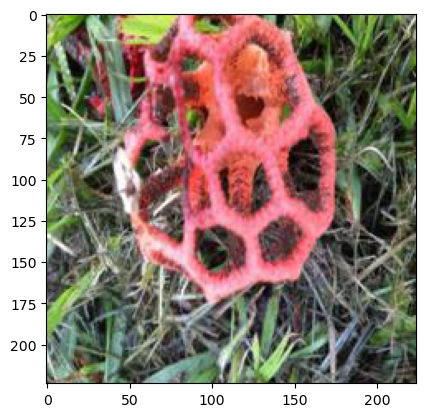

In [130]:
from tensorflow.keras.preprocessing import image

filename = data_test.path.iloc[0]

# A conserver pour d'autres tests rapides
#img = image.load_img('./Images/test/Agaricaceae/Chlorophyllum brunneum1866.jpg',target_size=(224,224))

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

## Générateur d'image
On met rotation_range à 180 pour générer des images dans tous les sens, ce qui devrait permettre d'éviter le flip (à valider)  


In [131]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parametres du générateur d'images pour l'entrainement
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [0.9,1.1],
                                   horizontal_flip = False)

# Générateur d'images pour le test
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [134]:
# Entrainment depuis des images données dans un dataset
batch_size = 20
train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                    directory = "",
                                                    x_col = "path",
                                                    y_col = "genus",
                                                    batch_size = batch_size,
                                                    class_mode = 'sparse', #"raw", #"'binary', #'sparse' ?
                                                    target_size = (224, 224))

# Validation avec les images de test sur le HDD
validation_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                        directory="",
                                                        x_col = "path",
                                                        y_col = "genus",
                                                        batch_size = batch_size,
                                                        class_mode = 'sparse',
                                                        target_size = (224, 224))

C:\Users\bhozj\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 11363 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 20637 validated image filenames belonging to 10 classes.
Found 5174 validated image filenames belonging to 10 classes.


C:\Users\bhozj\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 2826 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


## Elimination des fichiers corrompus sur le HDD
Nous avons pu constater que des fichiers corrompus faisaient planter les modèles 

In [135]:
from PIL import Image
tab = train_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i)
        
tab = validation_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i)

## Création du modèle ResNet50 pré-entrainé avec ImageNet

In [139]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), 
                      include_top=False, 
                      weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 10, activation = 'softmax'))

model.compile(optimizer = "adam", #optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                   loss = 'sparse_categorical_crossentropy', #loss = 'binary_crossentropy', 
                   metrics = ['acc'])


## Entrainement

In [140]:
history = model.fit(train_generator, 
                         validation_data = validation_generator, 
                         steps_per_epoch = len(data_train) // batch_size // 2,
                         validation_steps= len(data_test) // batch_size // 2,   
                         epochs = 10)

Epoch 1/10
800/800 [==============================] - 443s 550ms/step - loss: 0.9984 - acc: 0.6741 - val_loss: 0.6399 - val_acc: 0.7857
Epoch 2/10
800/800 [==============================] - 441s 552ms/step - loss: 0.7652 - acc: 0.7482 - val_loss: 0.5296 - val_acc: 0.8235
Epoch 3/10
800/800 [==============================] - 441s 551ms/step - loss: 0.7011 - acc: 0.7690 - val_loss: 0.5176 - val_acc: 0.8357
Epoch 4/10
800/800 [==============================] - 442s 552ms/step - loss: 0.6677 - acc: 0.7820 - val_loss: 0.4835 - val_acc: 0.8430
Epoch 5/10
800/800 [==============================] - 441s 551ms/step - loss: 0.6494 - acc: 0.7881 - val_loss: 0.4979 - val_acc: 0.8403
Epoch 6/10
800/800 [==============================] - 448s 560ms/step - loss: 0.6295 - acc: 0.7950 - val_loss: 0.4950 - val_acc: 0.8405
Epoch 7/10
800/800 [==============================] - 445s 556ms/step - loss: 0.6188 - acc: 0.7997 - val_loss: 0.4988 - val_acc: 0.8453
Epoch 8/10
800/800 [============================

In [141]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

## Graphique montrant l'évolution de la précision et la perte en fonction des epochs
On note un surapprentissage, la précision sur le test set étant significativement plus faible que sur le train set

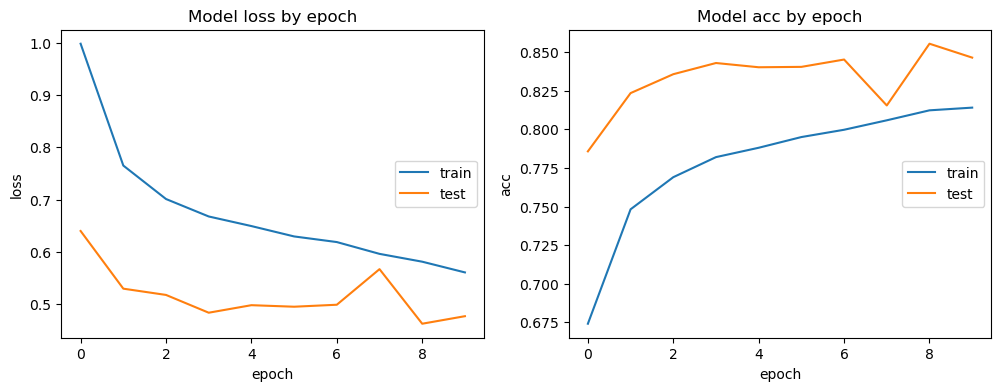

In [142]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


## Test prédictions 

On affiche les probabilités du champignon testé avec les 10 classes puis le nom de la classe choisie


In [143]:
#Récupération des classes
train_generator.get_classes(data_train, "genus")
labels = (train_generator.class_indices)
classes = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]

./ChampImages/Boletales/Sclerodermataceae/Scleroderma/Scleroderma citrinum/im602915.jpg


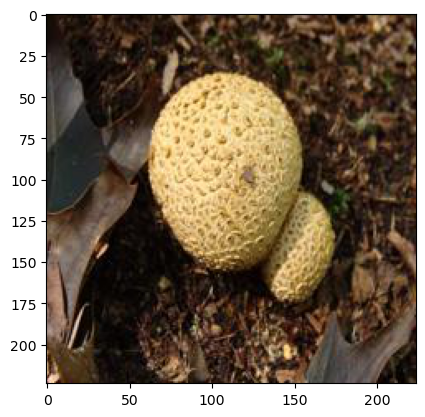

Probabilité pour les 10 classes : [[2.8327608e-03 1.3647815e-04 1.5835687e-09 5.9631571e-11 3.4497569e-07
  1.3870662e-07 3.2063326e-06 6.3158327e-06 1.4174944e-07 9.9702066e-01]]
Classe présentie : Scleroderma


In [145]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Phallales/Phallaceae/Clathrus/Clathrus archeri/im484295.jpg


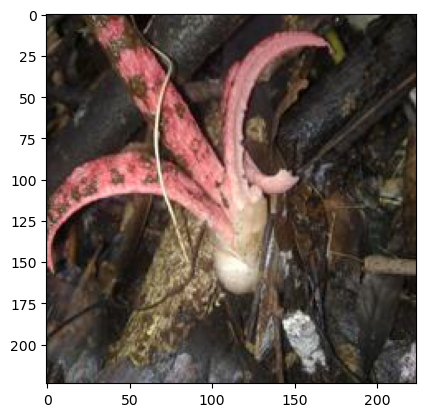

Probabilité pour les 10 classes : [[1.3955372e-06 9.7587817e-06 8.3824068e-09 8.5447122e-05 9.9990177e-01
  9.2142658e-09 1.3642344e-06 9.2798288e-08 4.8335389e-09 9.2991051e-08]]
Classe présentie : Clathrus


In [151]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Phallales/Phallaceae/Clathrus/Clathrus archeri/im1042037.jpg


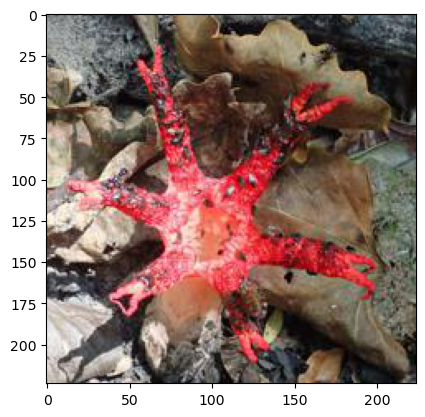

Probabilité pour les 10 classes : [[2.80521401e-13 2.65181876e-09 1.67541328e-15 1.34016025e-08
  1.00000000e+00 2.38287817e-15 1.13035198e-13 2.85837536e-14
  6.48339093e-15 1.09129936e-13]]
Classe présentie : Clathrus


In [153]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Geastrales/Geastraceae/Geastrum/Geastrum triplex/im793354.jpg


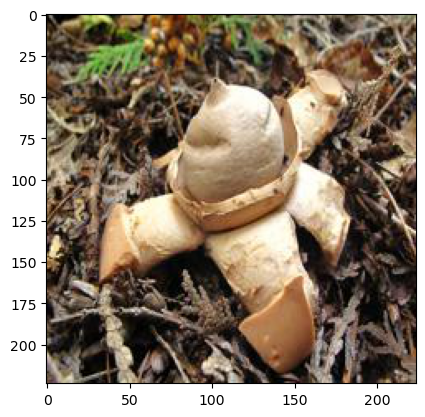

Probabilité pour les 10 classes : [[2.1416133e-07 1.3657127e-10 4.1558482e-11 6.8941915e-11 4.2368336e-09
  2.8497508e-11 9.9999976e-01 3.7570231e-08 3.1029269e-17 1.6689745e-10]]
Classe présentie : Geastrum


In [154]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])